In [325]:
#configure notebook
import warnings
warnings.filterwarnings('ignore')

#import packages
import numpy as np
import pandas as pd
import h5py
import sys
import matplotlib as mpl
import matplotlib.pyplot as plt
from lmfit import Model
from lmfit import Parameters
%matplotlib inline

from statistics import mean
import scipy
from pathlib import Path

#import IRCSP modules
from radiometric.LUT import create_LUT_df, determine_reference

from NUC.NUC_functions import import_NUC, apply_NUC, get_slice, determine_slope
from NUC.NUC_functions import determine_dark, apply_DFC_to_df
from NUC.NUC_functions import pixel_registration

from polarimetric.POL import make_polarized_df

COLOR = 'white'
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR

# Measurement Characterization and Filepaths

In [2]:
#choose filepath to desired data
path = '/Volumes/KESU/jun22/polarized/'
#note cam definitions are flipped as of FLIRPY ffc fix 
cal_file2 =  '/Volumes/KESU/calibration_files/cam1pixel.h5'
cal_file1 =  '/Volumes/KESU/calibration_files/cam2pixel.h5'

In [3]:
waves= np.linspace(7,12,61)
angles = np.linspace(0,359,360)

In [4]:
#select ROI
ymin2 = 105; ymax2 = 135;
ymin1 = 140; ymax1 = 170;

FOV = 53.51 ;
HFOV = 5;
view_angle = np.round(np.linspace(-HFOV,HFOV,ymax2-ymin2))

# Load NUC and determine DFC

In [5]:
'''LOAD slope from 2 point NUC'''
#choose filepath to desired data
save_path =   '/Volumes/KESU/calibration_files/'
name =  "NUC0519polarized.h5" 

hf = h5py.File(save_path+name, 'r')
M1 = hf.get('M1')
M2 = hf.get('M2')
T1 = hf.get('Tref1')
T2 = hf.get('Tref2')
ROI1 = hf.get('ROI1')
ROI2 = hf.get('ROI2')

## Check NUC

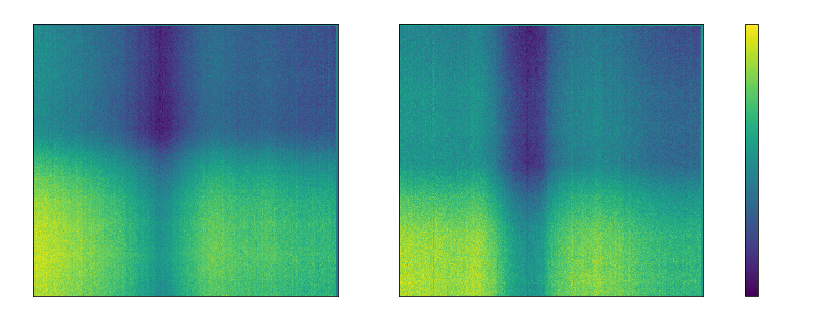

In [6]:
#plot DFCs, check appearance 
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5),sharey = True)
p1 = axes[0].pcolormesh(M1,shading = 'auto')
axes[0].set_title('Camera 1',fontsize = 14)

p2 = axes[1].pcolormesh(M2,shading = 'auto')
axes[1].set_title('Camera 2',fontsize = 14)
cbar = fig.colorbar(p1, ax=axes.ravel().tolist())
cbar.ax.set_ylabel('\n Gain Offset M',fontsize = 12)

plt.show()

In [7]:
#first, determine reference temp for each camera
ref_name  = '40C.h5'
dark_name = 'dark_low.h5'

tref1, tref2 = determine_reference(path,ref_name )

'''determine DFC'''
df_dark = create_LUT_df(path,dark_name)
df_ref = create_LUT_df(path,ref_name)
tref1,tref2,D1,D2 = determine_dark(df_dark,df_ref,M1,M2)

Ref T1 is 15.1
Ref T2 is 14.8


### Check appearance of DFCs

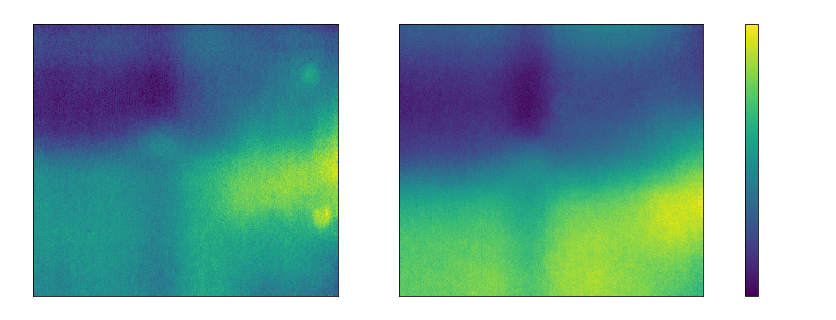

In [8]:
#plot DFCs, check appearance 
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5),sharey = True)
p1 = axes[0].pcolormesh(D1,shading = 'auto')
axes[0].set_title('Camera 1',fontsize = 14)

p2 = axes[1].pcolormesh(D2,shading = 'auto')
axes[1].set_title('Camera 2',fontsize = 14)
cbar = fig.colorbar(p1, ax=axes.ravel().tolist())
cbar.ax.set_ylabel('\n Dark Field Correction D',fontsize = 12)

plt.show()

### Check an intermediate image

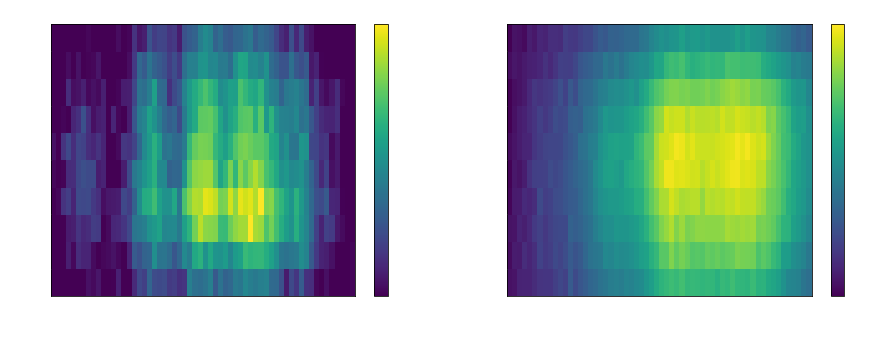

In [9]:
df_t = create_LUT_df(path,str(90)+'deg.h5')

c1 = df_t['imgs1'][1]-D1
c1[c1 <= 0] = 0

c2 = df_t['imgs2'][1]-D2
c2[c2 <= 0] = 0


#plot test images, test appearance
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5),sharey = True)

p1 = axes[0].pcolormesh(waves,view_angle,c1[ymin1:ymax1,100:160],shading = 'auto')
fig.colorbar(p1, ax=axes[0])
axes[0].set_title('Camera 1',fontsize = 14)
axes[0].set_ylabel('View Angles [$^\circ$]',fontsize = 14)
axes[0].set_xlabel('Wavlength [$\mu m$]',fontsize = 14)

p2 = axes[1].pcolormesh(waves,view_angle,c2[ymin2:ymax2,100:160],shading = 'auto')
axes[1].set_title('Camera 2',fontsize = 14)
axes[1].set_xlabel('Wavlength [$\mu m$]',fontsize = 14)
fig.colorbar(p2, ax=axes[1])

plt.show()


# Apply pixel registration and NUC

In [10]:
cam1 =  make_polarized_df(path, 'imgs1', 'temps1', cal_file1, waves, view_angle, ymin1, ymax1, angles, D1, D2, tref1, tref2, M1,M2)

In [11]:
cam2 = make_polarized_df(path, 'imgs2', 'temps2', cal_file2, waves, view_angle, ymin2, ymax2, angles, D1, D2, tref1, tref2, M1,M2)

In [12]:
w = 50
s = 15.0

c1max = cam1['mean'].max(axis = 0)
c1min = cam1['mean'].min(axis = 0)

c2max = cam2['mean'].max(axis = 0)
c2min = cam2['mean'].min(axis = 0)

w = 10
s = 15.0

for i in range(len(waves)):
    w = waves[i]
    c1= cam1[(cam1.wavelength == w) & (cam1.spatial == s)]
    c1= cam1[(cam1.wavelength == w) & (cam1.spatial == s)]
    
    # create figure and axis objects with subplots()
    fig,ax = plt.subplots()

    ax.plot(c1['aolp'],c1['mean'], color="red", marker=".")
    ax.set_xlabel("AOLP [$^\circ$]",fontsize=14)
    ax.set_ylabel('$C^1_{\lambda,\phi}$',color="red",fontsize=14)
    ax.set_ylim([c1min,c1max])

    # twin object for two different y-axis on the sample plot

    ax2=ax.twinx()
    # make a plot with different y-axis using second axis object
    ax2.plot(c2['aolp'],c2['mean'],color="blue",marker=".")
    ax2.set_ylim([c2min,c2max])
    ax2.set_ylabel('$C^2_{\lambda,\phi}$',color="blue",fontsize=14)
    plt.grid(True)
    plt.title('$\lambda$ = ' + str(round(waves[i],2))+' $\mu m$ , $\phi$ = ' + str(round(view_angle[int(s)],2))+'$^\circ$ ',fontsize = 16)

    plt.savefig('/Volumes/KESU/jun22/polarized/imgs/wave' +str(round(waves[i],2)) + '.png')
    plt.close()

In [118]:
Z1 = np.zeros([len(angles),len(waves)])
Z2 = np.zeros([len(angles),len(waves)])
for a in range(len(angles)):
    for w in range(len(waves)):
        c1 = cam1[(cam1.wavelength == waves[w]) & (cam1.spatial == s) & (cam1.aolp == a)]
        c2 = cam2[(cam2.wavelength == waves[w]) & (cam2.spatial == s) & (cam2.aolp == a)]
        Z1[a,w] = c1['mean']
        Z2[a,w] = c2['mean']

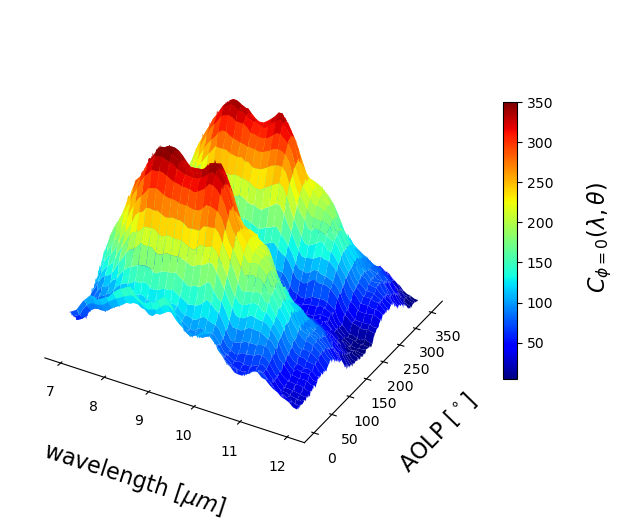

In [119]:
# Create figure and add axis
fig = plt.figure(figsize=(8,6))
ax = plt.subplot(111, projection='3d')

# Remove gray panes and axis grid
ax.xaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('white')
ax.yaxis.pane.fill = False
ax.yaxis.pane.set_edgecolor('white')
ax.zaxis.pane.fill = False
ax.zaxis.pane.set_edgecolor('white')
ax.grid(False)

# Remove gray panes and axis grid
ax.xaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('white')
ax.yaxis.pane.fill = False
ax.yaxis.pane.set_edgecolor('white')
ax.zaxis.pane.fill = False
ax.zaxis.pane.set_edgecolor('white')
ax.grid(False)
# Remove z-axis
ax.w_zaxis.line.set_lw(0.)
ax.set_zticks([])



# Set axis labels
ax.set_xlabel('wavelength [$\mu m$]', labelpad=20,fontsize = 16)
ax.set_ylabel('AOLP [$^\circ$]', labelpad=20,fontsize = 16)


X, Y = np.meshgrid(waves,angles)
plot = ax.plot_surface(X=X, Y=Y, Z=Z2, cmap='jet')

# Add colorbar
cbar = fig.colorbar(plot, ax=ax, shrink=0.6)
cbar.ax.set_ylabel('\n $ C_{\phi = 0} (\lambda , \\theta )$',fontsize = 16)
plt.show()

In [380]:
def mod(theta, delta,A,B):
    return A*np.cos(delta +2*theta) + B


In [381]:
def plot_fit(w,s,cam1,cam2):
    
    c1 = cam1[(cam1.wavelength == waves[w]) & (cam1.spatial == s) ]
    c2 = cam2[(cam2.wavelength == waves[w]) & (cam1.spatial == s) ]
    x1 = c1['aolp']; x2 = c2['aolp']
    y1 = c1['mean']; y2 = c2['mean']

    ggmodel = Model(mod)
    params = gmodel.make_params(delta = 1 , A =100 ,B = 100)
    result1 = gmodel.fit(y1, params, theta=x1 * (2* np.pi)/360)
    result2 = gmodel.fit(y2, params, theta=x2 * (2* np.pi)/360)

    # create figure and axis objects with subplots()


    plt.plot(x1, y1, 'bo')
    plt.plot(x1, result1.best_fit, 'k--', label='best fit')
    plt.xlabel("AOLP [$^\circ$]",fontsize=14)
    plt.ylabel('Response [ADU] ',fontsize=14)

    # make a plot with different y-axis using second axis object
    plt.plot(x2, y2, 'ro')
    plt.plot(x2, result2.best_fit, 'k--', label='best fit')

    plt.title('$\lambda$ = ' + str(round(waves[w],2))+' $\mu m$ , $\phi$ = ' + str(round(view_angle[int(s)],2))+'$^\circ$',fontsize = 16)
    plt.show()
    
    #result1.plot()
    #result2.plot()


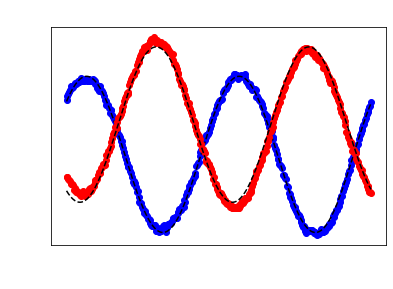

In [388]:
plot_fit(30,15.0,cam1,cam2)

In [383]:
def nrmse(result):
    er = np.array(result.residual)
    err = np.sqrt(np.mean(er**2))
    ymax = np.max(result1.best_fit)
    ymin = np.min(result1.best_fit)
    return err/(ymax-ymin)


In [384]:
delta1 = []; delta2 = []; 
A1 = []; A2 = []; 
B1 = []; B2 = [];
rmse1 = [] ; rmse2 = [];
nrmse1 = []; nrmse2 = [];

for s in [10]:#for s in range([len(view_angle)]):
    for w in range(len(waves)):
        c1 = cam1[(cam1.wavelength == waves[w]) & (cam1.spatial == s)]
        c2 = cam2[(cam2.wavelength == waves[w]) & (cam2.spatial == s)]
    
        x1 = c1['aolp']; x2 = c2['aolp']
        y1 = c1['mean']; y2 = c2['mean']

        gmodel = Model(mod)
        params = gmodel.make_params(delta = 1 , A =100 ,B = 100)
        result1 = gmodel.fit(y1, params, theta=x1 * (2* np.pi)/360)
        result2 = gmodel.fit(y2, params, theta=x2 * (2* np.pi)/360)
        
        delta1.append(result1.best_values['delta'])
        delta2.append(result2.best_values['delta'])
        
        A1.append(result1.best_values['A'])
        A2.append(result2.best_values['A'])
        
        B1.append(result1.best_values['B'])
        B2.append(result2.best_values['B'])
        
        nrmse1.append(nrmse(result1))
        nrmse2.append(nrmse(result2))
        
        rmse1.append( np.array(result1.residual))
        rmse2.append( np.array(result2.residual))

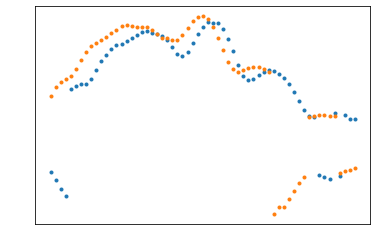

In [385]:
plt.plot(waves ,A1, '.')
plt.plot(waves, A2, '.')
plt.show()

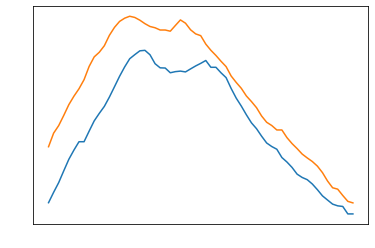

In [386]:
plt.plot(waves, B1)
plt.plot(waves, B2)
plt.show()

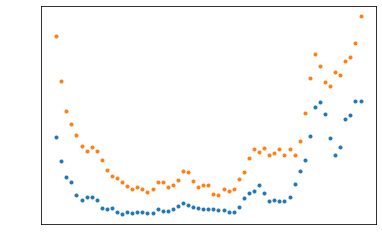

In [387]:
plt.plot(waves, np.multiply(nrmse1,100),'.')
plt.plot(waves, np.multiply(nrmse2,100),'.')
plt.ylabel('NRMSE [%]')
plt.show()